In [ ]:
%load_ext autoreload
%autoreload 2

In [21]:
import os
import cv2
from itertools import chain
from matplotlib import pyplot as plt

In [7]:

def listdir(path):
    if not os.path.isdir(path): return None
    contents = list(map(lambda x: os.path.join(path, x), os.listdir(path)))
    return contents

In [14]:
image_dir     = 'data_check-20250922T083054Z-1-001/data_check'
image_paths   = list(map(listdir, listdir(image_dir)))

In [15]:
sample_image_paths = image_paths[0]
sample_image_paths

['data_check-20250922T083054Z-1-001/data_check/different_1/101_6.tif',
 'data_check-20250922T083054Z-1-001/data_check/different_1/105_6.tif']

In [16]:
sample_images = list(map(cv2.imread, sample_image_paths))

### ORB Detector

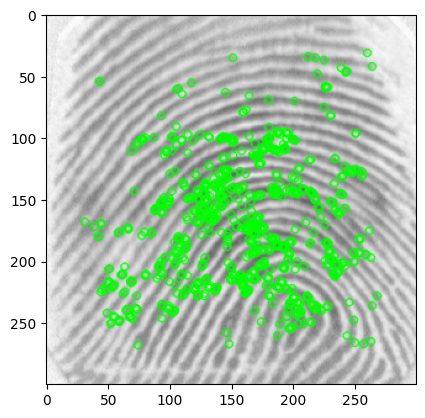

In [22]:
orb = cv2.ORB_create(nfeatures=1000)
keypoints, descriptors = orb.detectAndCompute(sample_images[0], None)
output_image = cv2.drawKeypoints(sample_images[0], keypoints, None, color=(0, 255, 0))
plt.imshow(output_image)

### SIFT Detector

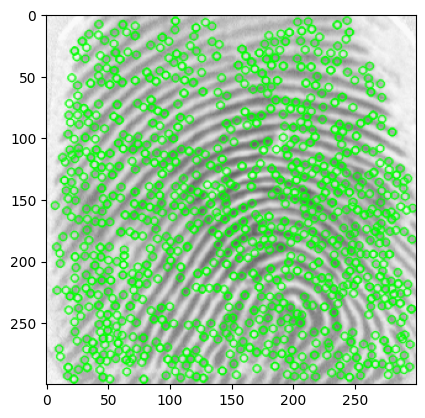

In [24]:
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(sample_images[0], None)
output_image = cv2.drawKeypoints(sample_images[0], keypoints, None, color=(0, 255, 0))
plt.imshow(output_image)

### Wrapper

In [86]:
def detector(algo, image):
    keypoints, descriptors = algo.detectAndCompute(image, None)
    return dict(
        image=image,
        keypoints=keypoints, 
        descriptors=descriptors
    )


In [ ]:
xSift = dict(
    x=detector(sift, sample_images[0]),
    y=detector(sift, sample_images[1]),
)

xOrb = dict(
    x=detector(orb, sample_images[0]),
    y=detector(orb, sample_images[1]),
)

### Brute Force Matcher
Use hamming distance for orb descriptors 

In [58]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(xOrb['x']['descriptors'], xOrb['y']['descriptors'])
matches = sorted(matches, key=lambda x: x.distance)
matches[:3]

[< cv2.DMatch 0x7c3e6c4f4bb0>,
 < cv2.DMatch 0x7c3e6c4f4ad0>,
 < cv2.DMatch 0x7c3e6c4f4af0>]

### FLANN Matcher

In [57]:
# Create FLANN parameters
FLANN_INDEX_KDTREE = 1  # Algorithm type for SIFT/SURF
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)  # K-D Tree with 5 trees
search_params = dict(checks=50)  # Number of times the tree is recursively traversed
 
# Initialize FLANN matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(xSift['x']['descriptors'], xSift['y']['descriptors'], k=2)
matches[:3] 

((< cv2.DMatch 0x7c3e6cf94f30>, < cv2.DMatch 0x7c3e6c4f4550>),
 (< cv2.DMatch 0x7c3e6c50b590>, < cv2.DMatch 0x7c3e6c50b450>),
 (< cv2.DMatch 0x7c3e6c50b5d0>, < cv2.DMatch 0x7c3e6c50b4f0>))

In [55]:
matches[0]

(< cv2.DMatch 0x7c3e6cf94530>, < cv2.DMatch 0x7c3e6cf94ed0>)

### Fingerprint Matching (ORB)

In [87]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [88]:
def preprocess_fingerprint(image_path):
    img = cv2.imread(image_path, 0)
    _, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return img_bin

In [89]:
def match_fingerprints(img1_path, img2_path):
    img1 = preprocess_fingerprint(img1_path)
    img2 = preprocess_fingerprint(img2_path)
 
    # Initialize ORB detector
    orb = cv2.ORB_create(nfeatures=1000)
 
    # Find keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    if des1 is None or des2 is None:
        return 0, None  # Return 0 matches if no descriptors found
 
    # Use Brute-Force Matcher with Hamming distance
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
 
    # KNN Match
    matches = bf.knnMatch(des1, des2, k=2)
 
    # Apply Lowe's ratio test (keep only good matches)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
 
    # Draw only good matches
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return len(good_matches), match_img

In [90]:
def process_dataset(dataset_path, results_folder):
    threshold = 20  # Adjust this based on tests
    y_true = []  # True labels (1 for same, 0 for different)
    y_pred = []  # Predicted labels
 
    # Create results folder if it does not exist
    os.makedirs(results_folder, exist_ok=True)
 
    # Loop through all subdirectories
    for folder in sorted(os.listdir(dataset_path)):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):  # Check if it's a valid directory
            image_files = [f for f in os.listdir(folder_path) if f.endswith(('.tif', '.png', '.jpg'))]
            if len(image_files) != 2:
                print(f"Skipping {folder}, expected 2 images but found {len(image_files)}")
                continue  # Skip if the folder doesn't have exactly 2 images
            img1_path = os.path.join(folder_path, image_files[0])
            img2_path = os.path.join(folder_path, image_files[1])
            match_count, match_img = match_fingerprints(img1_path, img2_path)
 
            # Determine the ground truth (expected label)
            actual_match = 1 if "same" in folder.lower() else 0  # 1 for same, 0 for different
            y_true.append(actual_match)
 
            # Decision based on good matches count
            predicted_match = 1 if match_count > threshold else 0
            y_pred.append(predicted_match)
            result = "orb_bf_matched" if predicted_match == 1 else "orb_bf_unmatched"
            print(f"{folder}: {result.upper()} ({match_count} good matches)")
 
            # Save match image in the results folder
            if match_img is not None:
                match_img_filename = f"{folder}_{result}.png"
                match_img_path = os.path.join(results_folder, match_img_filename)
                cv2.imwrite(match_img_path, match_img)
                print(f"Saved match image at: {match_img_path}")
 
    # Compute and display confusion matrix
    labels = ["Different (0)", "Same (1)"]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=(6, 5))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix orb_bf")
    plt.show()

different_1: ORB_BF_UNMATCHED (10 good matches)
Saved match image at: results/different_1_orb_bf_unmatched.png
different_10: ORB_BF_UNMATCHED (7 good matches)
Saved match image at: results/different_10_orb_bf_unmatched.png
different_2: ORB_BF_UNMATCHED (2 good matches)
Saved match image at: results/different_2_orb_bf_unmatched.png
different_3: ORB_BF_UNMATCHED (4 good matches)
Saved match image at: results/different_3_orb_bf_unmatched.png
different_4: ORB_BF_UNMATCHED (5 good matches)
Saved match image at: results/different_4_orb_bf_unmatched.png
different_5: ORB_BF_UNMATCHED (1 good matches)
Saved match image at: results/different_5_orb_bf_unmatched.png
different_6: ORB_BF_UNMATCHED (1 good matches)
Saved match image at: results/different_6_orb_bf_unmatched.png
different_7: ORB_BF_UNMATCHED (0 good matches)
Saved match image at: results/different_7_orb_bf_unmatched.png
different_8: ORB_BF_UNMATCHED (8 good matches)
Saved match image at: results/different_8_orb_bf_unmatched.png
differe

<Figure size 600x500 with 0 Axes>

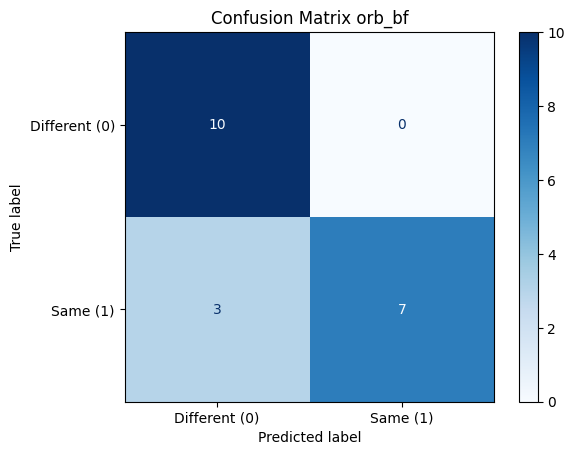

In [92]:
# Example usage
dataset_path = image_dir
results_folder = 'results'
process_dataset(dataset_path, results_folder)

In [93]:
def match_fingerprints(img1_path, img2_path):
    img1 = preprocess_fingerprint(img1_path)
    img2 = preprocess_fingerprint(img2_path)
 
    # Initialize SIFT detector
    sift = cv2.SIFT_create(nfeatures=1000)
 
    # Find keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    if des1 is None or des2 is None:
        return 0, None  # Return 0 matches if no descriptors found
 
    # FLANN parameters (KD-tree for SIFT)
    index_params = dict(algorithm=1, trees=5)  # KD-tree
    search_params = dict(checks=50)  # Number of checks for nearest neighbors
    flann = cv2.FlannBasedMatcher(index_params, search_params)
 
    # KNN Match
    matches = flann.knnMatch(des1, des2, k=2)
 
    # Apply Lowe's ratio test (keep only good matches)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
 
    # Draw only good matches
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return len(good_matches), match_img

In [94]:
def process_dataset(dataset_path, results_folder):
    threshold = 20  # Adjust this based on tests
    y_true = []  # True labels (1 for same, 0 for different)
    y_pred = []  # Predicted labels
    os.makedirs(results_folder, exist_ok=True)
    for folder in sorted(os.listdir(dataset_path)):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):  # Check if it's a valid directory
            image_files = [f for f in os.listdir(folder_path) if f.endswith(('.tif', '.png', '.jpg'))]
            if len(image_files) != 2:
                print(f"Skipping {folder}, expected 2 images but found {len(image_files)}")
                continue
            img1_path = os.path.join(folder_path, image_files[0])
            img2_path = os.path.join(folder_path, image_files[1])
            match_count, match_img = match_fingerprints(img1_path, img2_path)
 
            # Determine the ground truth
            actual_match = 1 if "same" in folder.lower() else 0  # 1 for same, 0 for different
            y_true.append(actual_match)
 
            # Decision based on good matches count
            predicted_match = 1 if match_count > threshold else 0
            y_pred.append(predicted_match)
            result = "sift_flann_matched" if predicted_match == 1 else "sift_flann_unmatched"
            print(f"{folder}: {result.upper()} ({match_count} good matches)")
            if match_img is not None:
                match_img_filename = f"{folder}_{result}.png"
                match_img_path = os.path.join(results_folder, match_img_filename)
                cv2.imwrite(match_img_path, match_img)
                print(f"Saved match image at: {match_img_path}")
 
    # Compute and display confusion matrix
    labels = ["Different (0)", "Same (1)"]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=(6, 5))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix sift_flann")
    plt.show()

In [96]:
image_dir

'data_check-20250922T083054Z-1-001/data_check'

different_1: SIFT_FLANN_UNMATCHED (10 good matches)
Saved match image at: results/sift/imgs/different_1_sift_flann_unmatched.png
different_10: SIFT_FLANN_UNMATCHED (6 good matches)
Saved match image at: results/sift/imgs/different_10_sift_flann_unmatched.png
different_2: SIFT_FLANN_UNMATCHED (4 good matches)
Saved match image at: results/sift/imgs/different_2_sift_flann_unmatched.png
different_3: SIFT_FLANN_UNMATCHED (6 good matches)
Saved match image at: results/sift/imgs/different_3_sift_flann_unmatched.png
different_4: SIFT_FLANN_UNMATCHED (14 good matches)
Saved match image at: results/sift/imgs/different_4_sift_flann_unmatched.png
different_5: SIFT_FLANN_UNMATCHED (4 good matches)
Saved match image at: results/sift/imgs/different_5_sift_flann_unmatched.png
different_6: SIFT_FLANN_UNMATCHED (12 good matches)
Saved match image at: results/sift/imgs/different_6_sift_flann_unmatched.png
different_7: SIFT_FLANN_UNMATCHED (15 good matches)
Saved match image at: results/sift/imgs/differe

<Figure size 600x500 with 0 Axes>

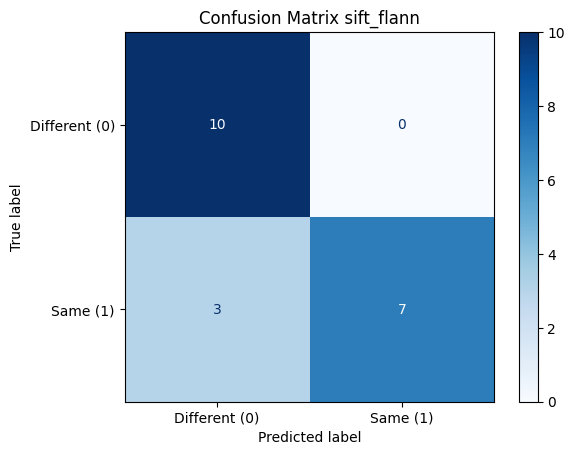

In [ ]:
# Example usage
dataset_path = image_dir
dataset_path = 'data_check-20250922T083054Z-1-001/data_check'
results_folder = 'results/sift/imgs'
process_dataset(dataset_path, results_folder)